In [25]:
# # Get data from SOLR and save it to a file
# from urllib.request import urlopen
# import json
# connection = urlopen('https://shapenet.org/solr/models3d/select?q=datasets%3AShapeNetCore+AND+wnhypersynsets%3A02828884&rows=100000&fl=fullId%2Ccategory%2Cwnsynset%2Cwnlemmas%2Cup%2Cfront%2Cunit%2Caligned.dims&wt=json&indent=true')
# response = json.load(connection)
# print(response['response']['numFound'], "documents found.")
# print(response)
# Print the name of each document.

# for doc in response['response']['docs']:
#   print(doc)

# with open('data.json', 'w') as outfile:
#     json.dump(response, outfile)


In [26]:
from pyvista import examples
from src.model_loader import ModelLoader 
import numpy as np
import pyvista as pv
from math import dist
import numpy as np

DATA_ROOT = "data\\shapenet_samples"
IMAGE_RES = 256
WINDOWSIZE = 256

def outRayFinder(pts):
    if len(pts) == 0:
        return None, None
    # Find the first element in pts that is differnt from pts[0] and return that point onelin
    if len(pts) > 2:
        points = np.array(pts)
        idx = np.where(np.isclose(points, points[0])  != [True, True, True])[0][1]
        return pts[0], pts[idx]
    elif len(pts) == 2:
        return pts[0], pts[1]
    else:
        return None,None
    
def createBaseMesh(mesh):#
    # Add a thin box below the mesh
    bounds = mesh.bounds
    rnge = (bounds[1] - bounds[0], bounds[5] - bounds[4], bounds[3] - bounds[2]) # x z y
    # print(rnge)

    expand = 10
    height = rnge[2] * 0.05
    center = np.array(mesh.center)
    center -= [0, mesh.center[2] + (bounds[3] + (height/3 )) , 0]

    width = rnge[0] * (1 + expand)
    length = rnge[1] * (1 + expand)
    base_mesh = pv.Cube(center, width, height, length)
    # base_mesh.rotate_x(-90, inplace=True)
    return base_mesh

data = ModelLoader(DATA_ROOT)

Loading Models: 100%|██████████| 3/3 [00:00<00:00, 10.83it/s]


In [27]:
# Model Augmentation
rotation = 180
catagory = "cow_mesh"
id_ = 0

# Load Data Paths
tex_path = data.get_model_paths()[catagory][id_].get_texture(0)
if tex_path is not None:
    obj_texture = pv.read_texture(tex_path)
obj_mesh = pv.read(data.get_model_paths()[catagory][id_].get_obj_path())
# create a box mesh with an edge at the origin
# obj_mesh = pv.Cube(center=(1,0,0))

# 
base_mesh = createBaseMesh(obj_mesh)
obj_mesh.rotate_vector(vector=(0, 1, 0), angle=rotation, inplace=True)

# Camera Setup
# dist_limit = -1
camera = pv.Camera()
# Camera Pos X(-5.0 to 5.0), Y(0.0 to 2.0), Z(0.0 to 5.0)
camera.position = (-5.0, 10.5, -4.5)

near_range = 0.3
far_range = 40
camera.clipping_range = (near_range, far_range)
c_pos = np.array(camera.position)

 
# # Calculates the mesh intersection of obj_mesh
# position = camera.GetViewPlaneNormal()
# end = (camera.position[0]*dist_limit, camera.position[1]*dist_limit,camera.position[2]*dist_limit)
# line = pv.Line(pointa=position, pointb=end, resolution= 1)
# points1, ind1 = obj_mesh.ray_trace(position, end)

# in1, out1 = outRayFinder(points1)
# print("Red Thickness:", dist(in1, out1) if (not in1 is None) else 0, "PTS =", in1, out1)

In [28]:
frustum = camera.view_frustum().copy()
plane = camera.view_frustum().copy()
# Furthest Frustum
plane = plane.extract_points(1)
plane = plane.extract_points(2)
plane = plane.extract_points(3)
# Inner Frustum
# plane = plane.extract_points(4)
# plane = plane.extract_points(5)
# plane.points

pyvista_ndarray([[ 11.500416 , -28.962645 ,  -4.069176 ],
                 [ -2.8394685, -28.962645 ,  11.864029 ],
                 [ 10.576661 , -17.399218 ,  23.938545 ],
                 [ 24.916546 , -17.399218 ,   8.005341 ]], dtype=float32)

In [29]:
# Given the corners of a squrare in 3d space, this function will return a grid of 3d points that are evenly spaced n x n x 1
def planeToGrid(frustum, n, center=None):
    # Find the center of the plane
    if center is not None:
        center = center
    else:
        center = frustum.center

    corners = frustum.points
    # Find the normal of the plane
    normal = np.cross(corners[1] - corners[0], corners[2] - corners[0])
    normal /= np.linalg.norm(normal)

    # Find the width and height of the plane
    width = dist(corners[0], corners[1])
    height = dist(corners[0], corners[3])

    # Create a grid of points that are evenly spaced
    grid = pv.Plane(center, normal, width, height, i_resolution=n-1, j_resolution=n-1)
    return grid, grid.ctp() # ctp = cell to point
    

_, end_ray_pts = planeToGrid(plane, IMAGE_RES)


In [30]:
pv.global_theme.background = (135, 206, 235)
pv.global_theme.smooth_shading = True
pv.global_theme.anti_aliasing = 'fxaa'
pv.set_jupyter_backend('pythreejs')

screenshot = True

show_edges = False
# show_pts = False
# show_planes = False

# 


# Plotting/Screenshot Code
pl = pv.Plotter(window_size=[WINDOWSIZE, WINDOWSIZE]) 

# Adds Object Meshes
try:
    obj = pl.add_mesh(obj_mesh, show_edges=show_edges, texture=obj_texture)
except :
    print("Textures Not Working!")
    obj = pl.add_mesh(obj_mesh, show_edges=show_edges)

# _ = pl.add_mesh(plane, style="wireframe",color="blue")
# _ = pl.add_mesh(frustum, style="wireframe",color="red")

# if in1 is not None:
#     intersect11 = pv.Plane(center = in1, direction = (1,0,0))
#     intersect12 = pv.Plane(center = out1, direction = (1,0,0))

#     if show_planes:
#         _ = pl.add_mesh(intersect11, color='r', opacity=0.5)
#         _ = pl.add_mesh(intersect12, color='r', opacity=0.5)

#     if show_pts:
#         _ = pl.add_points(in1, color='blue', point_size=50)
#         _ = pl.add_points(out1, color='blue', point_size= 50)

pl.camera = camera

# _ = pl.add_points(c_pos, color='red', point_size=10)
# _ = pl.add_points(end_ray_pts.points[1], color='white', point_size=1)
# _ = pl.add_points(start_ray_pts, color='white', point_size=1)
# points = np.array([c_pos, end_ray_pts.points[1]])
# actor = pl.add_lines(points, color='yellow', width=3)
if screenshot:
    # Screenshot code
    pl.screenshot()
    depth_img = pl.get_image_depth(fill_value=0)
    _ = pl.add_mesh(base_mesh,color='green')
    pl.ren_win.SetOffScreenRendering(5)
    img = pl.screenshot("result/moomoo.png",transparent_background=True, 
                        window_size=[IMAGE_RES,int(IMAGE_RES*pl.window_size[1]/pl.window_size[0])])
    
else:
    pl.show_axes()
    pl.show()

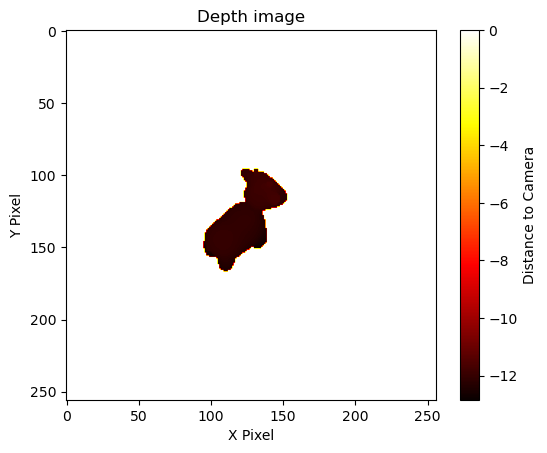

In [31]:
import matplotlib.pyplot as plt
photo = plt.imread("result/moomoo.png")

plt.figure()
plt.imshow(depth_img)
# plt.imshow(photo, alpha=0.5)

plt.colorbar(label='Distance to Camera')
plt.set_cmap('hot')
plt.title('Depth image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [32]:
thicc_map = np.zeros((IMAGE_RES*IMAGE_RES))
for i in range(len(end_ray_pts.points)):
    # Calculate ray intersection of each point in the grid
    points, _ = obj_mesh.ray_trace(c_pos, end_ray_pts.points[i])
    in1, out1 = outRayFinder(points)
    thicc_map[i] = dist(in1, out1) if (not in1 is None) else 0

thicc_map = np.flip(thicc_map.reshape(IMAGE_RES, IMAGE_RES))

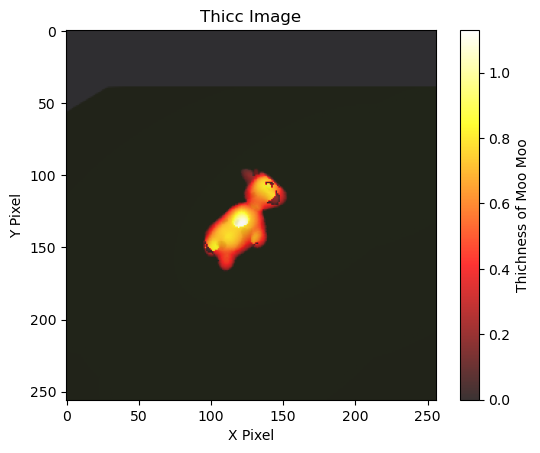

In [33]:
import matplotlib.pyplot as plt
photo = plt.imread("result/moomoo.png")

plt.figure()
plt.imshow(photo, alpha=0.5)

plt.imshow(thicc_map, alpha=0.8)

plt.colorbar(label='Thichness of Moo Moo')
plt.set_cmap('hot')
plt.title('Thicc Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()